In [39]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)


In [40]:
pipeline.model.model

T5ForConditionalGeneration(
  (shared): Embedding(4096, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(4096, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dropou

In [41]:
# import torch
# import torch.nn as nn
# from transformers import T5ForConditionalGeneration
# import copy

# class CustomT5Block(nn.Module):
#     def __init__(self, original_block):
#         super().__init__()
#         self.original_block = original_block

#         # Define the new feedforward layer
#         self.additional_ff = nn.Sequential(
#             nn.Linear(512, 512),  # Input 512, output 512
#             nn.ReLU()
#         )
        
#     def forward(self, x, **kwargs):
#         # Pass through the original block
#         x, *additional_outputs = self.original_block(x, **kwargs)
        
#         # Check if x is a tensor and not a tuple
#         if isinstance(x, tuple):
#             x = x[0]  # Get the first tensor if it's a tuple

#         # Pass through the additional feedforward layer
#         x = self.additional_ff(x)

#         return x

# class ModifiedT5(nn.Module):
#     def __init__(self, original_model):
#         super(ModifiedT5, self).__init__()
#         self.shared = original_model.shared
#         self.encoder = original_model.encoder
#         self.decoder = original_model.decoder
#         self.lm_head = original_model.lm_head
        
#         # Create new T5Block instances with the additional FF
#         self.encoder.block = nn.ModuleList(
#             CustomT5Block(block) for block in original_model.encoder.block
#         )
        
#         self.decoder.block = nn.ModuleList(
#             CustomT5Block(block) for block in original_model.decoder.block
#         )

#         # Define additional layers
#         self.additional_dense = nn.Linear(512, 512)
#         self.layer_norm = nn.LayerNorm(512)
#         self.dropout = nn.Dropout(0.1)

#     def forward(self, input_ids, attention_mask=None, decoder_input_ids=None):
#         # Pass input through the encoder
#         encoder_outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        
#         # Prepare decoder input IDs if not provided
#         if decoder_input_ids is None:
#             decoder_input_ids = input_ids  # Or use a different approach as per your task
        
#         # Pass the encoder outputs to the decoder
#         decoder_outputs = self.decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_outputs[0])
        
#         # Pass decoder outputs through the language model head
#         lm_logits = self.lm_head(decoder_outputs[0])
        
#         # Pass through additional dense layer, layer norm, and dropout
#         lm_logits = self.additional_dense(lm_logits)
#         lm_logits = self.layer_norm(lm_logits)
#         lm_logits = self.dropout(lm_logits)
        
#         return lm_logits

# # Usage
# original_model = T5ForConditionalGeneration.from_pretrained("amazon/chronos-t5-small")
# copied_model = copy.deepcopy(original_model)
# modified_model = ModifiedT5(copied_model)

# # # Test with dummy input
# # input_ids = torch.randint(0, 4096, (1, 10))  # Batch size 1, sequence length 10
# # output = modified_model(input_ids)


In [42]:
import copy
from transformers import T5ForConditionalGeneration
from transformers import set_seed
import torch.nn as nn

set_seed(42)

class CustomFFLayer(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define the new feedforward layer
        self.additional_ff = nn.Sequential(
            nn.Linear(512, 512),  # Input 512, output 400
            nn.ReLU()
        )
        
    def forward(self, x, **kwargs):        
        # Pass through the additional feedforward layer
        x = self.additional_ff(x)
        
        return x


class CustomT5(T5ForConditionalGeneration):
    def __init__(self, config):
        super().__init__(config)
        
        # Access the first encoder block
        first_encoder_block = self.encoder.block[0]
        customLayer = CustomFFLayer()
        # Duplicate the T5LayerFF layer (which is the second layer in the block)
        # extra_ff_layer = copy.deepcopy(first_encoder_block.layer[1])  # The FF layer is the second layer in the block

        first_encoder_block.layer.append(customLayer)  # Add it again
    
        # Do the same for the first decoder block
        # first_decoder_block = self.decoder.block[0]
        # extra_ff_layer_decoder = copy.deepcopy(first_decoder_block.layer[2])  # The FF layer is the third layer in the decoder block
        # first_decoder_block.layer.append(extra_ff_layer_decoder)

# Load the pre-trained model
original_model = T5ForConditionalGeneration.from_pretrained("amazon/chronos-t5-small")

copy_model = copy.deepcopy(original_model)

# Initialize custom model with the same configuration
custom_model = CustomT5(copy_model.config)

# Load the weights from the pre-trained model into the custom model
custom_model.load_state_dict(copy_model.state_dict(), strict=False)  # strict=False allows for architectural changes

# Now custom_model should share weights with the original model, except for the new FF layers


_IncompatibleKeys(missing_keys=['encoder.block.0.layer.2.additional_ff.0.weight', 'encoder.block.0.layer.2.additional_ff.0.bias'], unexpected_keys=[])

In [43]:
custom_model

CustomT5(
  (shared): Embedding(4096, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(4096, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dropout(p=0.1, inplace=F

In [44]:
import src.chronos.chronos
import importlib
importlib.reload(src.chronos.chronos)

from src.chronos.chronos import ChronosPipeline
import torch
import pandas as pd
from transformers import T5Tokenizer


pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)



context = torch.linspace(0, 100, 512).unsqueeze(0)


token_ids, attention_mask, scale = (
    pipeline.tokenizer.context_input_transform(context)
)

# import pprint
# pprint.pprint(output)
token_ids = token_ids[:, :-1]


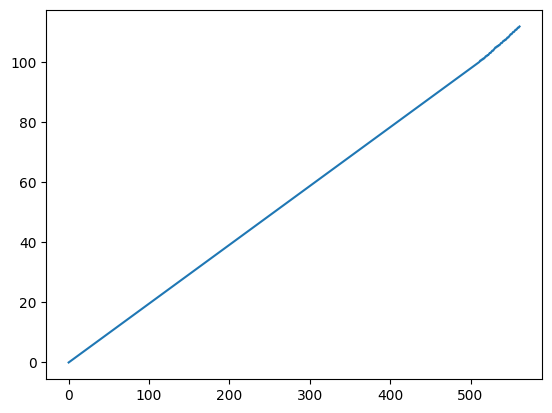

In [45]:
predictions_from_original_model = []
remaining = 50

while remaining > 0:
    token_ids, attention_mask, scale = pipeline.tokenizer.context_input_transform(
        context
    )
    samples = original_model.generate(
                input_ids=token_ids,
                attention_mask=attention_mask, 
                min_new_tokens=50,
                max_new_tokens=50,
                do_sample=True,
                num_return_sequences=1,
                eos_token_id=pipeline.model.config.eos_token_id,
                pad_token_id=pipeline.model.config.pad_token_id)
    
    prediction = pipeline.tokenizer.output_transform(
        samples.to(scale.device), scale
    )

    predictions_from_original_model.append(prediction)
    remaining -= prediction.shape[-1]

    if remaining <= 0:
        break

    context = torch.cat(
        [context, prediction.median(dim=1).values], dim=-1
    )



data_custom_to_plot = torch.concat((context,predictions_from_original_model[0][0,:,1:]),dim=1).squeeze(0).tolist()


import matplotlib.pyplot as plt
import numpy as np
data_custom_to_plot = np.array(data_custom_to_plot)
plt.plot(data_custom_to_plot)

In [46]:
predictions_from_custom_model = []
remaining = 50

while remaining > 0:
    token_ids, attention_mask, scale = pipeline.tokenizer.context_input_transform(
        context
    )
    samples = custom_model.generate(
                input_ids=token_ids,
                attention_mask=attention_mask, 
                min_new_tokens=50,
                max_new_tokens=50,
                do_sample=True,
                num_return_sequences=1,
                eos_token_id=pipeline.model.config.eos_token_id,
                pad_token_id=pipeline.model.config.pad_token_id)
    
    prediction = pipeline.tokenizer.output_transform(
        samples.to(scale.device), scale
    )

    predictions_from_custom_model.append(prediction)
    remaining -= prediction.shape[-1]

    if remaining <= 0:
        break

    context = torch.cat(
        [context, prediction.median(dim=1).values], dim=-1
    )



data_custom_to_plot = torch.concat((context,predictions_from_custom_model[0][0,:,1:]),dim=1).squeeze(0).tolist()


import matplotlib.pyplot as plt
import numpy as np
data_custom_to_plot = np.array(data_custom_to_plot)
plt.plot(data_custom_to_plot)

RuntimeError: The size of tensor a (512) must match the size of tensor b (400) at non-singleton dimension 2

In [35]:
forecast = pipeline.predict(context=context, prediction_length=50, num_samples=1)

In [38]:
forecast - predictions_from_original_model[0][:,:,1:]

tensor([[[  0.0000,   0.0000,  -0.3666,   0.0000,   0.0000,   0.3666,   0.0000,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -0.3666,
            0.0000,  -0.3666,   0.0000, 103.7390,   0.0000,  -0.3666,  -0.3666,
            0.0000,  -0.3666,   0.0000,   0.0000,   0.0000,   0.0000,  -0.3666,
            0.0000,  -0.3666,   0.0000,   0.0000,   0.0000,  -0.3666,  -0.3666,
            0.0000,  -0.3666,   0.0000,  -0.3666,   0.3666,   0.0000,   0.0000,
            0.0000,   0.0000,  -0.3666,   0.0000,   0.0000,   0.0000,  -0.3666,
            0.0000]]])